# Training an MLP on Time Series Data
This notebook demonstrates how to train a Multi-Layer Perceptron (MLP) on synthetic time series data using the ThreeWToolkit.

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path

# Adiciona o diretório raiz ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [ ]:
from ThreeWToolkit.preprocessing import windowing
from ThreeWToolkit.trainer.trainer import ModelTrainer, TrainerConfig
from ThreeWToolkit.models.mlp import MLPConfig
from ThreeWToolkit.dataset import ParquetDataset
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig

In [ ]:
dataset_path = Path("../../data/raw/")
ds_config = ParquetDatasetConfig(
    path=dataset_path, clean_data=True, download=False, target_class=[0, 1, 2]
)
ds = ParquetDataset(ds_config)
ds[19]


{'signal':                      ABER-CKGL  ABER-CKP  ESTADO-DHSV  ESTADO-M1  ESTADO-M2  \
 timestamp                                                                     
 2018-05-13 04:49:38        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:39        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:40        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:41        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:42        0.0       0.0          0.0        0.0        0.0   
 ...                        ...       ...          ...        ...        ...   
 2018-05-13 12:49:32        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:33        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:34        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:35        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:36        0.

In [7]:
window_size = 1000
mlp_config = MLPConfig(
    input_size=window_size,
    hidden_sizes=(32, 16),
    output_size=3,
    random_seed=11,
    activation_function="relu",
    regularization=None,
)

trainer_config = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=32,
    epochs=20,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cross_validation=False,
    shuffle_train=True
)

trainer = ModelTrainer(trainer_config)
print(trainer.model)

MLP(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=1000, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [8]:
ds[0]["signal"].columns

Index(['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2',
       'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2',
       'ESTADO-XO', 'P-ANULAR', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKP',
       'P-PDG', 'P-TPT', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT'],
      dtype='object')

In [9]:
selected_col = "T-TPT"
x_train = []
y_train = []
dfs = []

for event in tqdm(ds):
    #normalized_signal = normalize(event["signal"][selected_col])
    windowed_signal = windowing(
        event["signal"][selected_col],
        window="hann",
        window_size=window_size,
        overlap=0.5,
        pad_last_window=True,
    )
    windowed_signal.drop(columns=["win"], inplace=True)
    windowed_signal["label"] = np.unique(event["label"]["class"])[0]
    dfs.append(windowed_signal)

100%|██████████| 760/760 [00:37<00:00, 20.01it/s]


In [10]:
dfs_final = pd.concat(dfs, ignore_index=True, axis=0)
dfs_final

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_992,val_993,val_994,val_995,val_996,val_997,val_998,val_999,val_1000,label
0,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
1,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
2,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
3,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
4,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44390,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000521,0.000411,0.000315,0.000231,0.000161,0.000103,0.000058,0.000026,0.000006,0
44391,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000521,0.000411,0.000315,0.000231,0.000161,0.000103,0.000058,0.000026,0.000006,0
44392,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000521,0.000411,0.000315,0.000231,0.000161,0.000103,0.000058,0.000026,0.000006,0
44393,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [11]:
dfs_final["label"].value_counts()

label
0    24633
1    18267
2     1495
Name: count, dtype: int64

In [12]:
# Train the MLP model using the new ModelTrainer interface
trainer.train(x_train=dfs_final.iloc[:, :-1], y_train=dfs_final["label"].astype(int))

In [13]:
# Evaluate model performance on validation set using ModelTrainer's test method
from ThreeWToolkit.metrics import accuracy_score, recall_score

test_loss, test_metrics = trainer.test(
    dfs_final.iloc[:, :-1], dfs_final["label"].astype(int), metrics=[
        accuracy_score,
        lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')
    ]
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

Test Loss: 0.1845
Test Metrics: {'accuracy_score': 0.9528775763036378, '<lambda>': 0.9528775763036378}


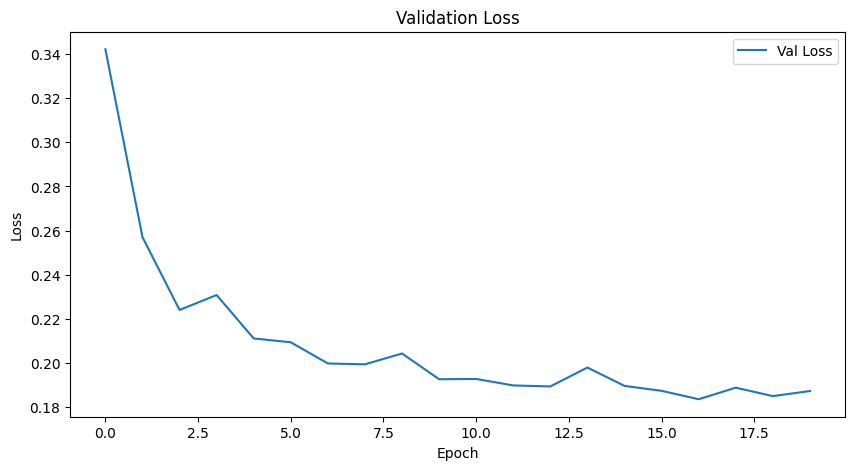

In [14]:
# Visualize training history
plt.figure(figsize=(10, 5))
for i, fold_hist in enumerate(trainer.history):
    if fold_hist is not None:
        plt.plot(fold_hist["val_loss"], label="Val Loss")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

__________

In [15]:
# Example: Setup TrainerConfig with Kfold for cross-validation
trainer_config_cv = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=32,
    epochs=20,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cross_validation=True,
    n_splits=5
)

trainer_cv = ModelTrainer(trainer_config_cv)

In [16]:
# Train the MLP model using cross-validation (StratifiedKFold)
# This will run 5-fold cross-validation and store history for each fold in trainer_cv.history

trainer_cv.train(x_train=dfs_final.iloc[:, :-1], y_train=dfs_final["label"].astype(int))

Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


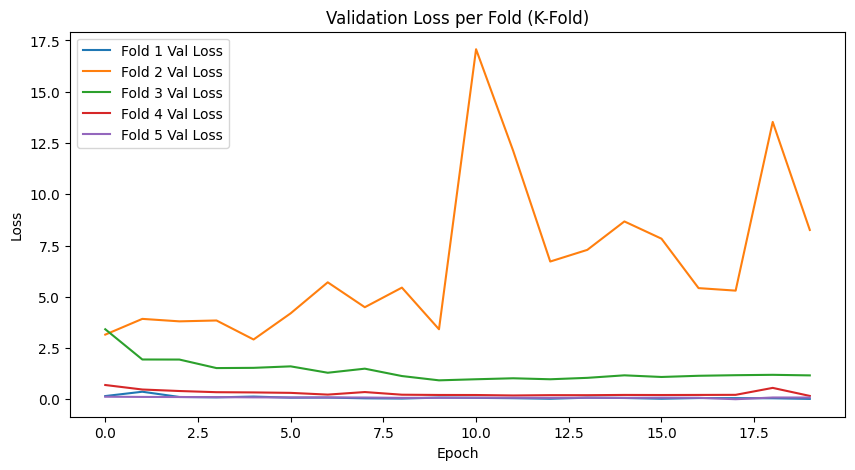

In [18]:
# Visualize K-Fold training history for all folds
plt.figure(figsize=(10, 5))
for i, fold_hist in enumerate(trainer_cv.history):
    if fold_hist is not None:
        plt.plot(fold_hist["val_loss"], label=f"Fold {i + 1} Val Loss")
plt.title("Validation Loss per Fold (K-Fold)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()